In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

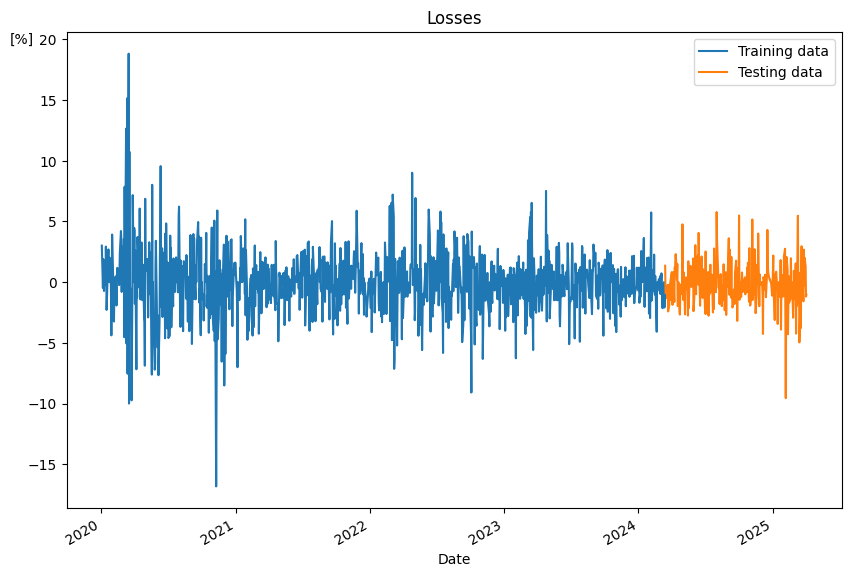

In [3]:
san = pd.read_csv('dane/san.csv', index_col=0, skiprows=2)
san['log_return'] = np.log1p(san.iloc[:,0].pct_change())
san = san.log_return
san.index = pd.to_datetime(san.index, format='%Y-%m-%d')
san.dropna(inplace=True)

ls = 100 * (1 - np.exp(san))
n = ls.size
train, test = ls.iloc[:int(n*0.8)], ls.iloc[int(n*0.8):]

plt.figure(figsize=(10,7))
train.plot()
test.plot()
plt.legend(["Training data","Testing data"])
plt.ylabel("[%]", rotation = 0, y = 0.97)
plt.title("Losses")
plt.show()

# Value at risk

## Metoda historyczna zwykła

### Dane treningowe

#### VaR<sub>95%</sub>

In [4]:
q95_empirical = train.quantile(0.95)
print(q95_empirical)

3.878468294428562


#### VaR<sub>99%</sub>

In [5]:
q99_empirical = train.quantile(0.99)
print(q99_empirical)

7.040686255858221


#### Wykresy

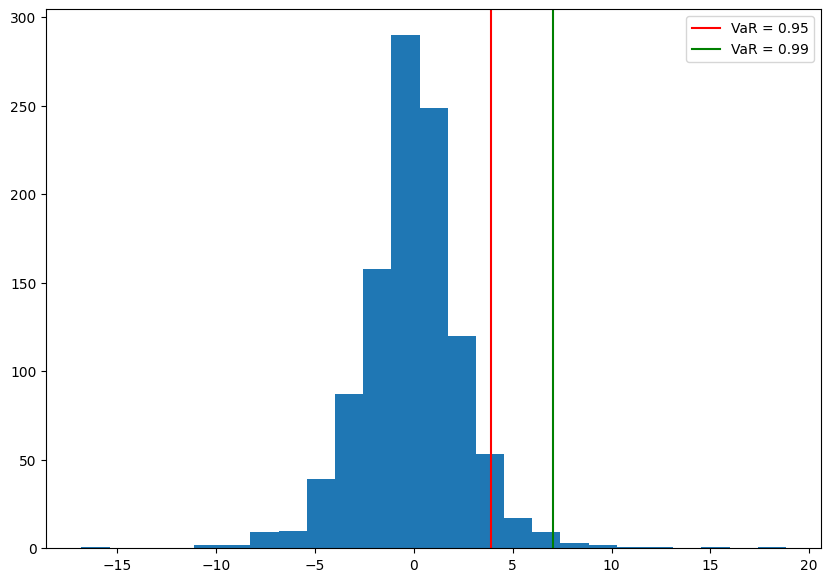

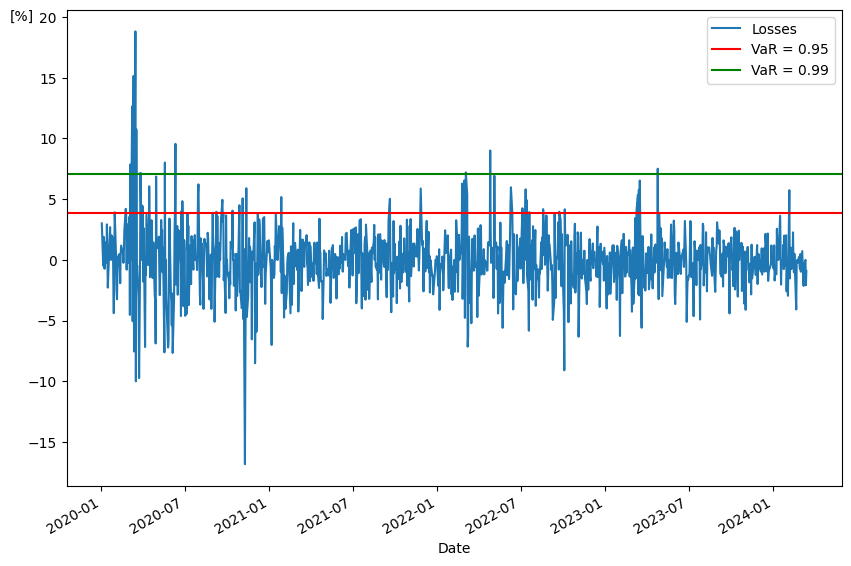

In [6]:
plt.figure(figsize=(10,7))
train.hist(grid=False, bins=25)
plt.axvline(x = q95_empirical, color = 'r', label = 'VaR = 0.95')
plt.axvline(x = q99_empirical, color = 'g', label = 'VaR = 0.99')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
train.plot(label = 'Losses')
plt.axhline(y=q95_empirical, color='r', linestyle='-', label = 'VaR = 0.95');
plt.axhline(y=q99_empirical, color='g', linestyle='-', label = 'VaR = 0.99');
plt.legend()
plt.ylabel("[%]", rotation = 0, y = 0.97)
plt.show()

### Dane testowe

#### VaR<sub>95%</sub>

In [7]:
n_test = len(test)
cut_train = train.iloc[len(train) - n_test:]

quantiles95 = [cut_train.quantile(0.95)] + [0] * (n_test - 1)
exceptions95 = [0] * n_test
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles95[i] = data.quantile(0.95)   
    if test[i - 1] > quantiles95[i - 1]:
        exceptions95[i - 1] = 1

print(np.mean(exceptions95))

0.06439393939393939


#### VaR<sub>99%</sub>

In [8]:
quantiles99 = [cut_train.quantile(0.99)] + [0] * (n_test - 1)
exceptions99 = [0] * n_test
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles99[i] = data.quantile(0.99)   
    if test[i - 1] > quantiles99[i - 1]:
        exceptions99[i - 1] = 1

print(np.mean(exceptions99))

0.022727272727272728


#### Wykresy

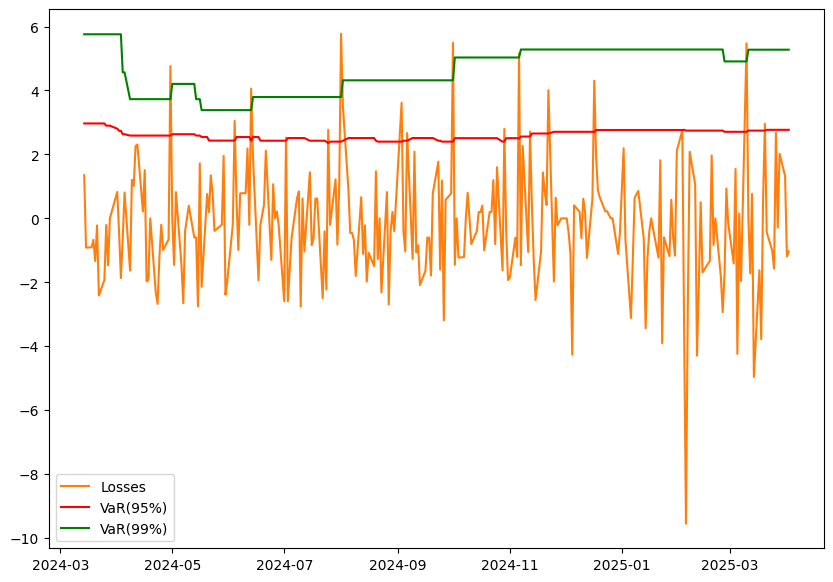

In [9]:
plt.figure(figsize=(10,7))
plt.plot(test, color='tab:orange', label = 'Losses')
plt.plot(test.index, quantiles95, c='r', label='VaR(95%)')
plt.plot(test.index, quantiles99, c='g', label='VaR(99%)')
plt.legend()
plt.show()

## Metoda historyczna ważona

### Dane treningowe

In [10]:
train_n = len(train)
lam = 0.97
wts_train = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, train_n + 1)] 
weights_dict_train = {'Returns':train[::-1], 'Weights': wts_train}
wts_returns_train = pd.DataFrame(weights_dict_train)
sorted_wts_train = wts_returns_train.sort_values(by='Returns')
sorted_wts_train['Cumulative'] = sorted_wts_train.Weights.cumsum()

display(sorted_wts_train)

sorted_wts_train = sorted_wts_train.reset_index(drop=True)

,Returns,Weights,Cumulative
Date,,,
2020-11-09,-16.822430,2.391147e-13,2.391147e-13
2020-03-17,-10.000021,1.570155e-15,2.406849e-13
2020-03-24,-9.734523,1.828453e-15,2.425133e-13
2022-10-04,-9.090906,5.031730e-07,5.031732e-07
2020-12-01,-8.510636,3.775985e-13,5.031736e-07
...,...,...,...
2020-06-11,9.558831,9.764239e-15,1.000000e+00
2020-03-18,10.743809,1.618716e-15,1.000000e+00
2020-03-09,12.647057,1.307895e-15,1.000000e+00


#### VaR<sub>95%</sub>

In [11]:
sorted_wts_train[sorted_wts_train.Cumulative <= 0.95].Returns.idxmax()

np.int64(905)

In [12]:
sorted_wts_train.loc[905:906]

,Returns,Weights,Cumulative
905,2.261306,0.000013,0.946737
906,2.266999,0.016314,0.963051


In [13]:
xp95 = sorted_wts_train.loc[905:906, 'Cumulative'].values
fp95 = sorted_wts_train.loc[905:906, 'Returns'].values
VaR95_weighted = np.interp(0.95, xp95, fp95)
VaR95_weighted

np.float64(2.2624445278535505)

#### VaR<sub>99%</sub>

In [14]:
sorted_wts_train[sorted_wts_train.Cumulative <= 0.99].Returns.idxmax()

np.int64(1030)

In [15]:
sorted_wts_train.loc[1030:1031]

,Returns,Weights,Cumulative
1030,5.462178,2.750423e-14,0.986346
1031,5.741619,1.358896e-02,0.999935


In [16]:
xp99 = sorted_wts_train.loc[1030:1031, 'Cumulative'].values
fp99 = sorted_wts_train.loc[1030:1031, 'Returns'].values
VaR99_weighted = np.interp(0.99, xp99, fp99)
VaR99_weighted

np.float64(5.537325678138095)

#### Wykresy

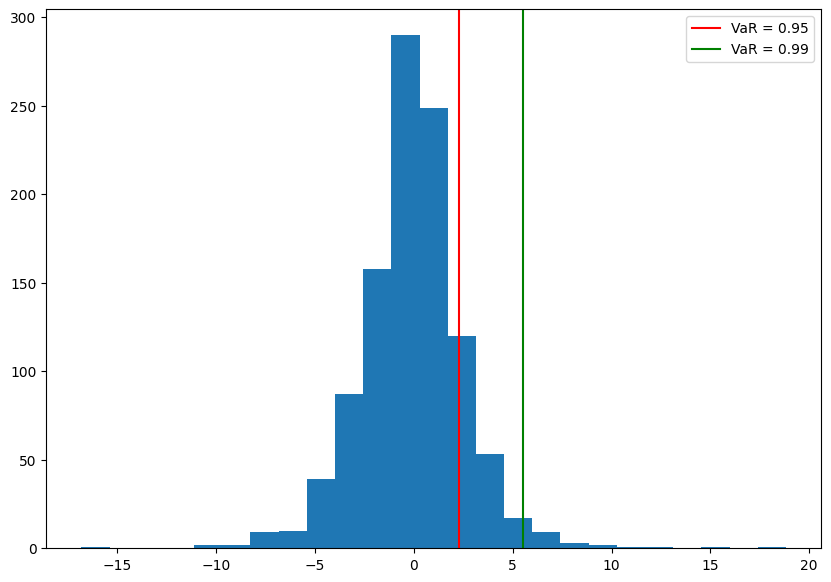

In [17]:
plt.figure(figsize=(10,7))
train.hist(grid=False, bins=25)
plt.axvline(x = VaR95_weighted, color = 'r', label = 'VaR = 0.95')
plt.axvline(x = VaR99_weighted, color = 'g', label = 'VaR = 0.99')
plt.legend()
plt.show()

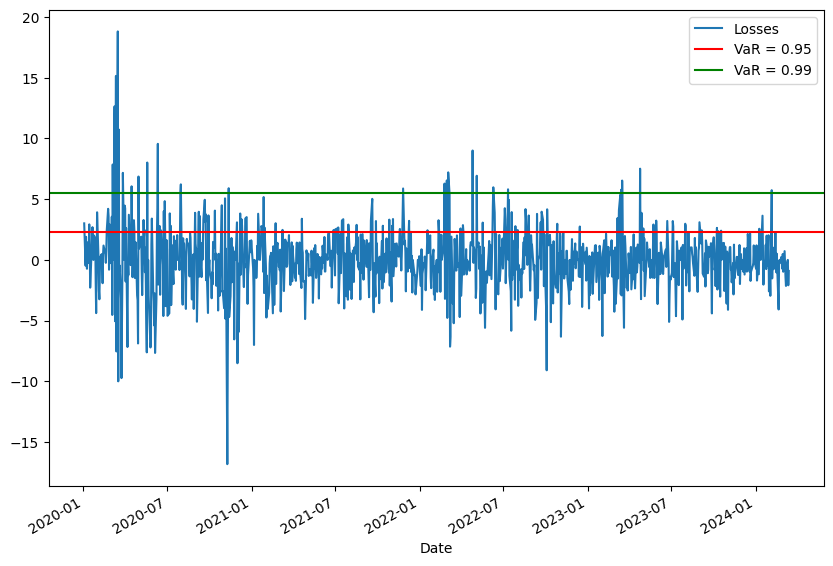

In [18]:
plt.figure(figsize=(10,7))
train.plot(label = 'Losses')
plt.axhline(y=VaR95_weighted, color='r', linestyle='-', label = 'VaR = 0.95')
plt.axhline(y=VaR99_weighted, color='g', linestyle='-', label = 'VaR = 0.99')
plt.legend()
plt.show()

### Dane testowe

In [19]:
def historical_weighted_VaR(data, level):
    # wagi
    n = len(data)
    wts_data = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, n + 1)]
    # data frame
    weights_dict_data = {'Returns':data[::-1], 'Weights': wts_data}
    wts_returns_data = pd.DataFrame(weights_dict_data)
    # dystrybuanta
    sorted_wts_data = wts_returns_data.sort_values(by='Returns')
    sorted_wts_data['Cumulative'] = sorted_wts_data.Weights.cumsum()
    sorted_wts_data = sorted_wts_data.reset_index(drop=True)
    searched_index = sorted_wts_data[sorted_wts_data.Cumulative <= level].Returns.idxmax()
    xp_data = sorted_wts_data.loc[searched_index:searched_index + 1, 'Cumulative'].values
    fp_data = sorted_wts_data.loc[searched_index:searched_index + 1, 'Returns'].values
    # interpolacja
    return np.interp(level, xp_data, fp_data)

#### VaR<sub>95%</sub>

In [20]:
quantiles95_weighted = [historical_weighted_VaR(cut_train, 0.95)] + [0] * (n_test - 1)
exceptions95_weighted = [0] * n_test

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles95_weighted[i - 1] = historical_weighted_VaR(data, 0.95)
    if test[i - 1] > quantiles95_weighted[i - 1]:
        exceptions95_weighted[i - 1] = 1

print(np.mean(exceptions95_weighted))

0.06818181818181818


#### VaR<sub>99%</sub>

In [21]:
quantiles99_weighted = [historical_weighted_VaR(cut_train, 0.99)] + [0] * (n_test - 1)
exceptions99_weighted = [0] * n_test

for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    quantiles99_weighted[i - 1] = historical_weighted_VaR(data, 0.99)
    if test[i - 1] > quantiles99_weighted[i - 1]:
        exceptions99_weighted[i - 1] = 1

print(np.mean(exceptions99_weighted))

0.015151515151515152


#### Wykresy

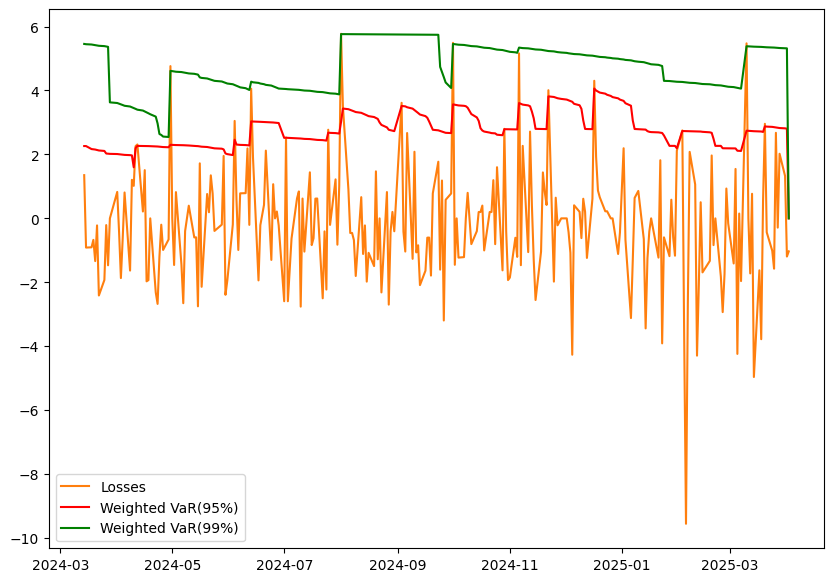

In [22]:
plt.figure(figsize=(10,7))
plt.plot(test, color = 'tab:orange', label = 'Losses')
plt.plot(test.index, quantiles95_weighted, c='r', label='Weighted VaR(95%)')
plt.plot(test.index, quantiles99_weighted, c='g', label='Weighted VaR(99%)')
plt.legend()
plt.show()

## Porównanie metod historycznych

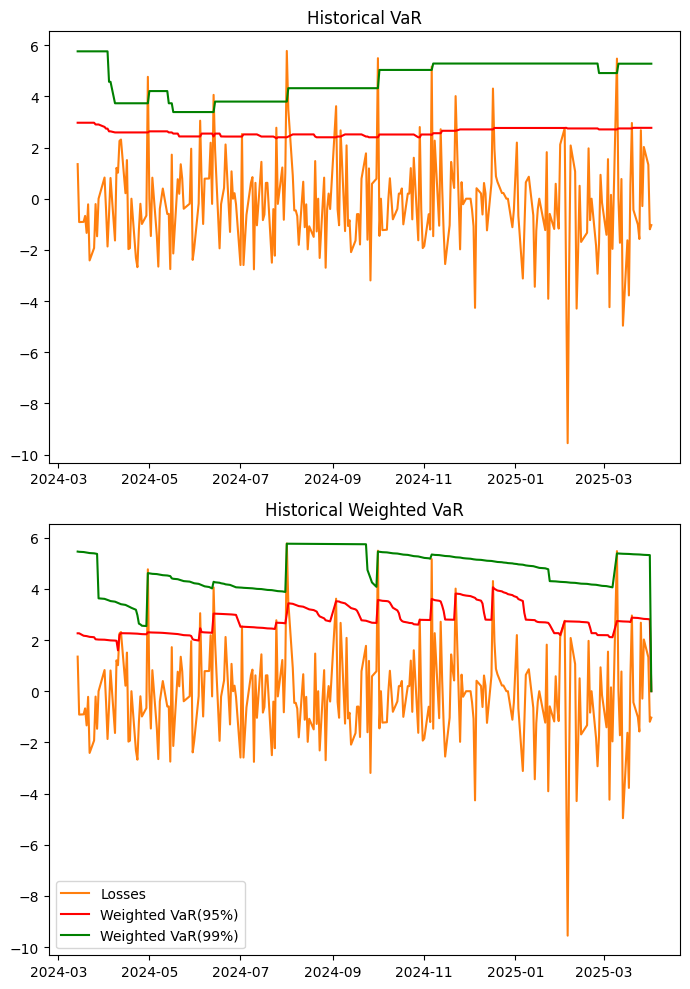

In [23]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(7)

ax1.set_title('Historical VaR')
ax1.plot(test, label='Losses', color = 'tab:orange')
ax1.plot(test.index, quantiles95, c='r', label='VaR(95%)')
ax1.plot(test.index, quantiles99, c='g', label='VaR(99%)')

ax2.set_title('Historical Weighted VaR')
ax2.plot(test, label='Losses', color = 'tab:orange')
ax2.plot(test.index, quantiles95_weighted, c='r', label='Weighted VaR(95%)')
ax2.plot(test.index, quantiles99_weighted, c='g', label='Weighted VaR(99%)')
ax2.legend()
plt.tight_layout()
plt.show()

## GARCH

### ...

## Prarametryczna

## ...

## Parametryczna Monte Carlo

### Dane treningowe

#### Rozkład t Studenta

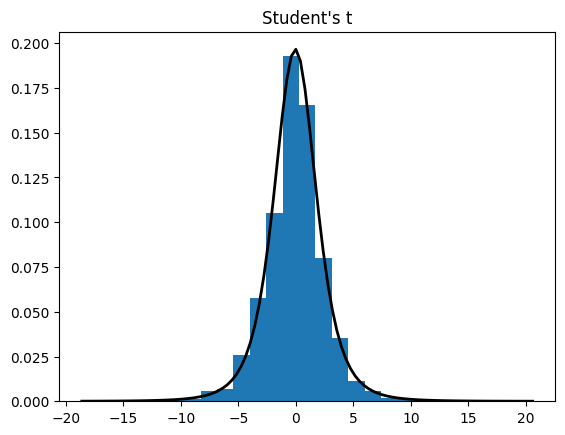

df: 3.9929101829792293
loc: -0.04268882531940828
scale: 1.906849016890947


In [24]:
data = np.array(train)

df, loc, scale = stats.t.fit(data)

plt.hist(data, bins=25, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.t.pdf(x, df, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Student's t")
plt.show()

print("df:",df)
print("loc:",loc)
print("scale:",scale)

#### Rozkład normalny

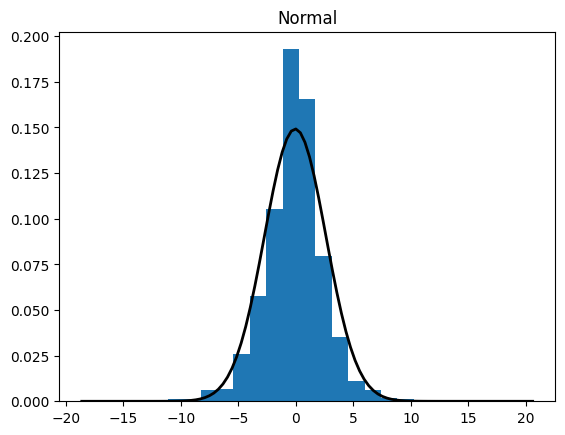

mu: -0.04773548857764561
std: 2.6739351629213566


In [25]:
mu, std = stats.norm.fit(data)

plt.hist(data, bins=25, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal")
plt.show()

print("mu:",mu)
print("std:",std)

#### Rozkład generalized extreme value

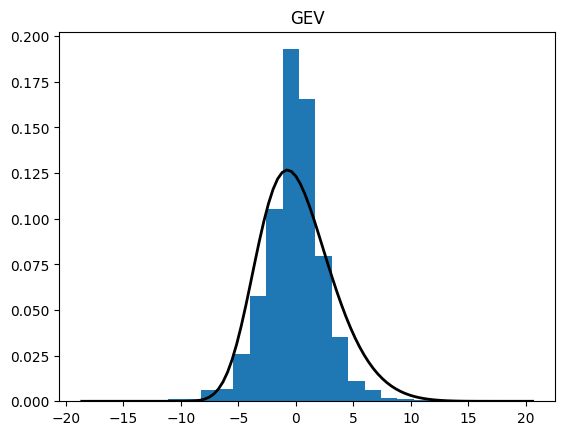

shape: 0.13895515995918095
loc: -1.1658797707991346
scale: 2.933048827750485


In [26]:
shape, loc, scale = stats.genextreme.fit(data)

plt.hist(data, bins=25, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.genextreme.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.title("GEV")
plt.show()

print("shape:",shape)
print("loc:",loc)
print("scale:",scale)

### Dane testowe

#### Rozkład t studenta

C:\Users\nadia\AppData\Local\Temp\ipykernel_11332\2392951514.py:14: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index,exc95MCt,color='r',label='t VaR(95%)')


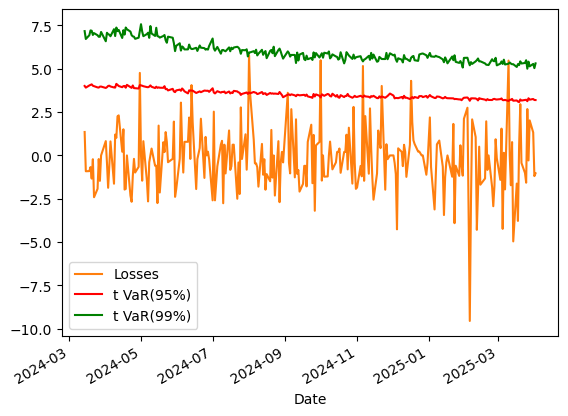

In [27]:
MC = 10000
pred = []
exc95MCt = []
exc99MCt = []
for i in range(test.size):
    train_shifted = ls.iloc[i:int(n*0.8)+i]
    df, loc, scale = stats.t.fit(train_shifted)
    pred.append(stats.t.rvs(df,loc,scale,MC))
    exc95MCt.append(np.quantile(pred[i],0.95))
    exc99MCt.append(np.quantile(pred[i],0.99))
pred = np.array(pred)

test.plot(label='Losses',color='tab:orange')
plt.plot(test.index,exc95MCt,color='r',label='t VaR(95%)')
plt.plot(test.index,exc99MCt,color='g',label='t VaR(99%)')
plt.legend()
plt.show()

#### Rozkład normalny

C:\Users\nadia\AppData\Local\Temp\ipykernel_11332\2679090356.py:13: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index,exc95MCnorm,color='r',label='normal VaR(95%)')


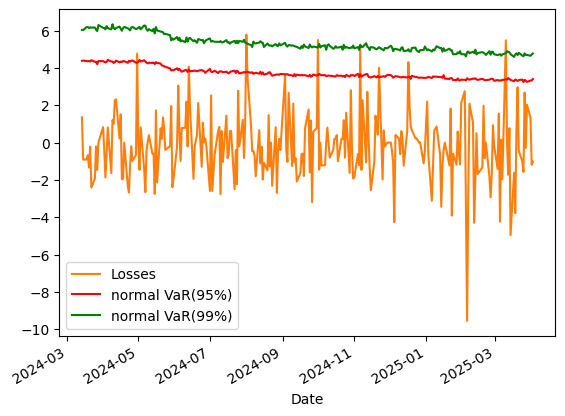

In [28]:
pred = []
exc95MCnorm = []
exc99MCnorm = []
for i in range(test.size):
    train_shifted = ls.iloc[i:int(n*0.8)+i]
    mu, std = stats.norm.fit(train_shifted)
    pred.append(stats.norm.rvs(mu, std, MC))
    exc95MCnorm.append(np.quantile(pred[i],0.95))
    exc99MCnorm.append(np.quantile(pred[i],0.99))
pred = np.array(pred)

test.plot(label='Losses',color='tab:orange')
plt.plot(test.index,exc95MCnorm,color='r',label='normal VaR(95%)')
plt.plot(test.index,exc99MCnorm,color='g',label='normal VaR(99%)')
plt.legend()
plt.show()

#### Rozkład generalized extreme value

C:\Users\nadia\AppData\Local\Temp\ipykernel_11332\4239710060.py:14: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index,exc95MCt,color='r',label='GEV VaR(95%)')


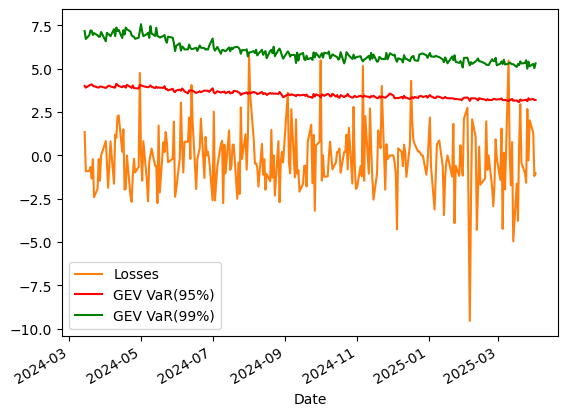

In [29]:
MC = 10000
pred = []
exc95MCgev = []
exc99MCgev = []
for i in range(test.size):
    train_shifted = ls.iloc[i:int(n*0.8)+i]
    shape, loc, scale = stats.genextreme.fit(train_shifted)
    pred.append(stats.t.rvs(shape,loc,scale,MC))
    exc95MCgev.append(np.quantile(pred[i],0.95))
    exc99MCgev.append(np.quantile(pred[i],0.99))
pred = np.array(pred)

test.plot(label='Losses',color='tab:orange')
plt.plot(test.index,exc95MCt,color='r',label='GEV VaR(95%)')
plt.plot(test.index,exc99MCt,color='g',label='GEV VaR(99%)')
plt.legend()
plt.show()

# Entropic value at risk

## Metoda historyczna zwykła

#### EVaR<sub>95%</sub>

In [30]:
expectiles95 = [stats.expectile(cut_train, alpha=0.95)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles95[i] = stats.expectile(data, alpha=0.95)  

#### EVaR<sub>99%</sub>

In [31]:
expectiles99 = [stats.expectile(cut_train, alpha=0.99)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles99[i] = stats.expectile(data, alpha=0.99)   

## Metoda historyczna ważona

#### EVaR<sub>95%</sub>

In [32]:
wts_evar = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, n_test + 1)][::-1]
expectiles95_weighted = [stats.expectile(cut_train, alpha=0.95, weights=wts_evar)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles95_weighted[i] = stats.expectile(data, alpha=0.95, weights=wts_evar)

#### EVaR<sub>99%</sub>

In [33]:
expectiles99_weighted = [stats.expectile(cut_train, alpha=0.99, weights=wts_evar)] + [0] * (n_test - 1)
for i in range(1, n_test):
    data = pd.concat([cut_train[i:], test[:i]], ignore_index=True)
    expectiles99_weighted[i] = stats.expectile(data, alpha=0.99, weights=wts_evar)   

## Porównanie

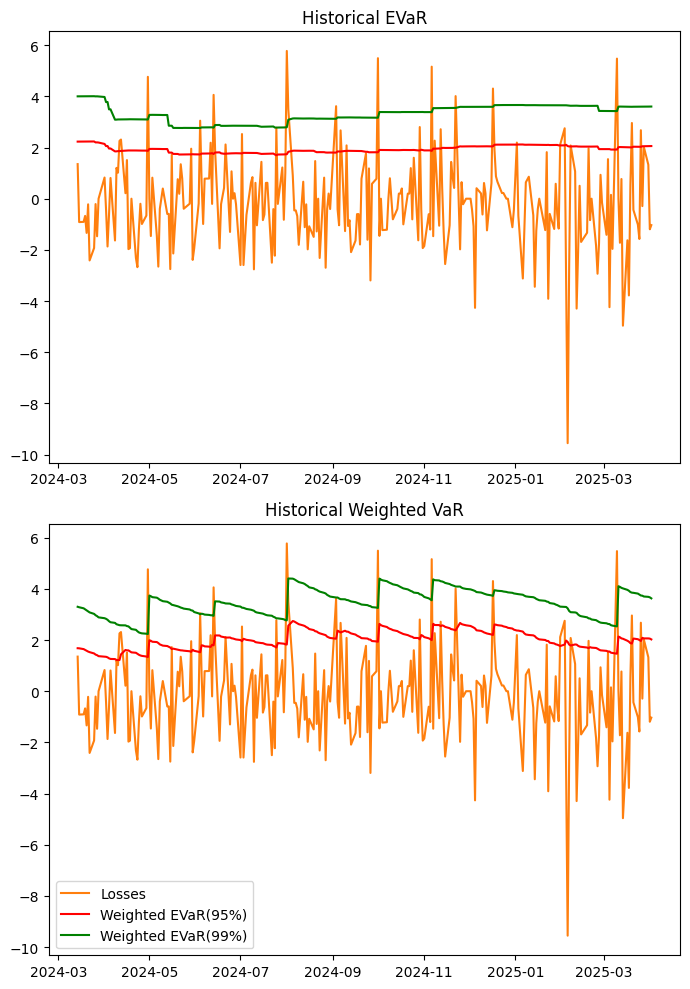

In [35]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(7)

ax1.set_title('Historical EVaR')
ax1.plot(test, label='Losses', color = 'tab:orange')
ax1.plot(test.index, expectiles95, c='r', label='EVaR(95%)')
ax1.plot(test.index, expectiles99, c='g', label='EVaR(99%)')

ax2.set_title('Historical Weighted VaR')
ax2.plot(test, label='Losses', color = 'tab:orange')
ax2.plot(test.index, expectiles95_weighted, c='r', label='Weighted EVaR(95%)')
ax2.plot(test.index, expectiles99_weighted, c='g', label='Weighted EVaR(99%)')
ax2.legend()
plt.tight_layout()
plt.show()